<a href="https://colab.research.google.com/github/idoFinder/Audio_Analysis_FFT_and_ML/blob/main/pipeline_1_fft_with_ML_classifiers_Ido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
import soundfile as sf 
from scipy.fft import fft, ifft
from tempfile import TemporaryFile
from sklearn.model_selection import train_test_split , StratifiedKFold, GridSearchCV
import xgboost as xgb
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, scale, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Ideas for pipelines:

We decided to start with binary classification

- Convert the raw signal into a more informative representations:
-- Smooth fft ---> classic ML classifiers (LR, SVM, RF etc.)
-- Extract multiple statistics out of the signals (ingoring the time dimantion) 
--> ML classifiers
-- LSTM with raw signal's statistics (using sliding window)
-- LSTM with fft: The input of each LSTM cell is a single frequency amplitude

Imbalanced data metrices:
- AUC, F1, TPR, MCC (highly correlated with F1)


# Pipeline 1 - Smooth fft with classic ML classifiers

## Load labels and set raw data path


In [ ]:
labels_df = pd.read_csv('/content/drive/MyDrive/ML_2/main_project/labels_df.csv')
records_path = '/content/drive/MyDrive/ML_2/main_project/relevant_train_seperated'
records_file_names = os.listdir(records_path)
print(len(records_file_names))

In [ ]:
labels_df

## Preprocess raw data

### Functions

In [ ]:
def calc_fft(raw_record):
  N = len(raw_record) # Number of sample points
  yf = fft(raw_record)
  forier_y = 2.0/N * np.abs(yf[0:N//2]) # use only the positive side of y-axis
  return forier_y

# smoothing a sequential vector and reducing its dimentionality 
def sliding_window(x, window_size, stride, operation):  
    a = np.array(x)
    nrows = ((a.size-window_size)//stride)+1
    n = a.strides[0]
    bins = np.lib.stride_tricks.as_strided(a, shape=(nrows,window_size), strides=(stride*n,n))
    if operation == 'mean':
        return bins.mean(axis=1)
    if operation == 'max':
        return bins.max(axis=1)
    if operation == 'min':
        return bins.min(axis=1)
    if operation == 'sum':
        return bins.sum(axis=1)   

def plot_signal(signal):
  plt.figure(figsize=(8,4))
  plt.title(f'Signal dim:{len(signal)}')
  plt.plot(signal)


def plot_signal_with_given_y_range(signal,y_range):
  plt.figure(figsize=(8,4))
  plt.ylim(y_range)
  plt.title(f'Signal dim:{len(signal)}')
  plt.plot(signal)


### Explore smoothing effect

In [ ]:
#### Set the sliding windows Params ####
window_size = 2500
stride = 500
operation = 'mean'
########################################

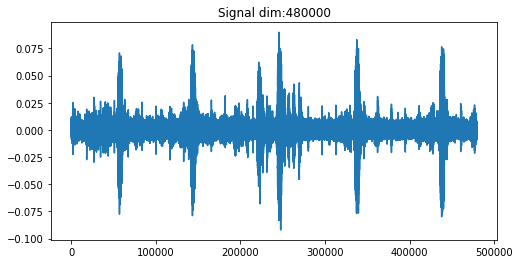

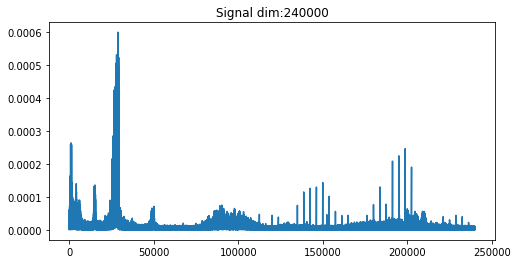

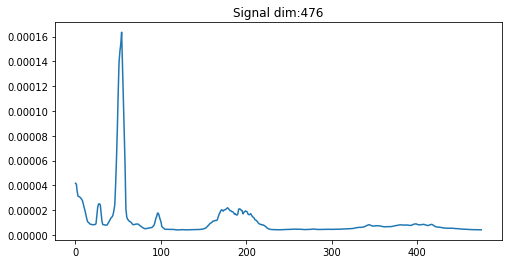

In [ ]:
# load a single record
record_1 = np.load(f'{records_path}/{records_file_names[1119]}')
# apply fft
record_1_fft = calc_fft(record_1)
# record_1_fft = np.log(record_1_fft)

y_min = min(record_1_fft)
y_max = max(record_1_fft)
# smooth the fft
record_1_smooth_fft = sliding_window(record_1_fft,window_size, stride, operation)

# plot the process
plot_signal(record_1)
plot_signal(record_1_fft)
plot_signal(record_1_smooth_fft)
# plot_signal_with_given_y_range(record_1_smooth_fft,[y_min,y_max])

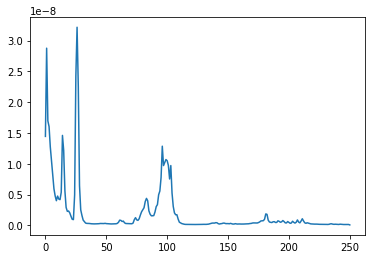

In [ ]:
# FFT per window
import scipy.io as sio
from scipy.signal import welch, hann
from scipy.fft import fft, ifft


fs = 48000
nblock = 500
overlap = nblock*0.5
win = hann(nblock)

X = record_1
f, X = welch(X, fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True,detrend=False)
plt.plot(X)
# plot_signal_with_given_y_range(X,[y_min,y_max])

### Generate fft dataframe in batches

In [ ]:
# handle crashing due to RAM issues
num_of_batches = 5
batch_size = round(len(records_file_names) / num_of_batches)

for batch in range(num_of_batches):
  # we create a dataframe to store the smoothed fft together with theirs lables
  data_df = pd.DataFrame(columns=['record_id','fft','label'])
  records_to_add = []

  print('Working on batch', batch + 1)
  batch_files = records_file_names[batch*batch_size:batch*batch_size + batch_size]

  for idx, file_name in enumerate(batch_files):
    record_id = file_name.split('.')[0]
    raw_record = np.load(f'{records_path}/{file_name}')
    # apply fft
    record_fft = calc_fft(raw_record)
    record_label = labels_df[labels_df['sample_id']==record_id].label.values[0]
    new_record = {'record_id':record_id, 'fft':record_fft, 'label':record_label}
    records_to_add.append(new_record)

    if idx%50 == 0:
      print(f'- Finished {idx}/{len(batch_files)}')

  data_df = data_df.append(records_to_add, ignore_index=True)
  save_path = '/content/drive/MyDrive/ML_2/main_project/proccesed_data_in_df'
  data_df.to_parquet(f'{save_path}/train_data_fft_batch_{batch + 1}.parquet', index=False)
  # data_df.to_pickle(f'{save_path}/train_data_fft_batch_{batch + 1}.pkl')

  del records_to_add
  del data_df

### Generate smooth fft in single dataframe 

In [ ]:
data_path = '/content/drive/MyDrive/ML_2/main_project/proccesed_data_in_df/fft_data_in_batches'

# smoothing params
window_size = 100
stride = 100
operation = 'max'

data_smooth_df_records = []
for batch_idx, batch in enumerate(os.listdir(data_path)):
  print(f'loading batch {batch_idx+1}')
  fft_data = pd.read_parquet(f'{data_path}/{batch}')

  for row_idx in range(fft_data.shape[0]):
    curr_row = fft_data.iloc[row_idx]
    smooth_fft = sliding_window(curr_row.fft, window_size, stride, operation)

    curr_record = {'record_id':curr_row.record_id,
                   'smooth_fft':smooth_fft,
                   'label':curr_row.label}

    data_smooth_df_records.append(curr_record)
    if row_idx%100 == 0:
      print(f' - {row_idx+1}/{fft_data.shape[0]}')
    
  del fft_data

print(f'Finished -- total of {len(data_smooth_df_records)} records')

# save dataframe
data_smooth_df = pd.DataFrame(data_smooth_df_records)
save_path = '/content/drive/MyDrive/ML_2/main_project/proccesed_data_in_df/smooth_fft_df'
data_smooth_df.to_parquet(f'{save_path}/smooth_fft_winsize_{window_size}_stride_{stride}_op_{operation}.parquet', index=False)
data_smooth_df.shape

# Modeling

### Functions



In [ ]:
## Functions
def calc_metrics(conf_matrix, Y_proba, Y_test):
    AUC = roc_auc_score(Y_test, Y_proba)

    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]

    TPR = TP / (TP + FN)  # recall
    FPR = FP / (FP + TN)
    ACC = (TP + TN) / (TP + TN + FP + FN)
    Precision = TP / (TP + FP)
    F1_score = 2 * ((Precision * TPR) / (Precision + TPR))

    metrics_dict = {
        'TPR': round(TPR, 2),
        'FPR': round(FPR, 2),
        'ACC': round(ACC, 2),
        'Precision': round(Precision, 2),
        'F1_score': round(F1_score, 2),
        'AUC': round(AUC, 4),
    }

    return metrics_dict


def get_predictions(Y_proba, threshold):
    Y_pred_final = []
    for p in Y_proba:
        if p > threshold:
            Y_pred_final.append(1)
        else:
            Y_pred_final.append(0)

    return Y_pred_final


def get_predictions_multiclass(Y_proba):
  Y_pred_final = []
  for p in Y_proba:
    pred = np.argmax(p)
    Y_pred_final.append(pred)
  return Y_pred_final


def get_features_IG(X,y):

  features_indxes = [f'col_{i}' for i in range(X.shape[1])]
  mut_info_score = mutual_info_classif(X, y)

  feature_importance_df = pd.DataFrame(columns=['feature', 'importance'])
  for idx, imp in enumerate(mut_info_score):
      new_record = {
          'feature': features_indxes[idx],
          'importance': imp
      }

      feature_importance_df = feature_importance_df.append(new_record, ignore_index=True)

  feature_importance_df = feature_importance_df.sort_values(['importance'], ascending=False)

  return feature_importance_df


def creatMat(y_true,y_pred,title):
  a = np.zeros([24,24])
  for j in range(len(y_true)):
    a[y_true[j]-1][y_pred[j]-1] += 1
  
  sns.heatmap(a)
  plt.xticks(ticks = [i for i in range(24)] ,labels = [i for i in range(1,25)],rotation = 70)
  plt.yticks(ticks = [i for i in range(0,24,2)] ,labels = [i for i in range(1,25,2)])

  plt.xlabel('True')
  plt.ylabel('Pred')
  plt.title(title)


### Prepare data for classic ML models

In [ ]:
def load_data_for_multicalss(winsize,stride,op, show_barplot):
  df_to_load = f'smooth_fft_winsize_{winsize}_stride_{stride}_op_{op}.parquet'
  data_smooth_df = pd.read_parquet(f'/content/drive/MyDrive/ML_2/main_project/proccesed_data_in_df/smooth_fft_df/{df_to_load}')

  ### init the ML dataframe with the features columns first
  columns = [f'f_{i}' for i in range(len(data_smooth_df.iloc[0].smooth_fft))]
  ML_data = pd.DataFrame(columns=columns)

  ### populate the df with the smooth fft as features
  df_records_to_add = []
  for row_index in range(data_smooth_df.shape[0]):
    curr_vec = data_smooth_df.iloc[row_index].smooth_fft
    curr_df_row = pd.DataFrame(curr_vec.reshape(-1, len(curr_vec)), columns=columns)
    df_records_to_add.append(curr_df_row)

  ML_data = ML_data.append(df_records_to_add, ignore_index=True)

  ### add the id and the label columns
  ML_data.insert(0, 'record_id', data_smooth_df['record_id'])
  ML_data['label'] = data_smooth_df['label']
  pd.set_option('display.max_columns', 8)

  ### convert to multiclass 
  ML_data = ML_data[ML_data['label']>0]
  if show_barplot:
    ML_data.groupby(['label']).count()['f_1'].plot.bar(rot=0,grid=True)
    plt.title(f'Total of {ML_data.shape[0]} samples | feature dim: {ML_data.shape[1]-2}')
    plt.show()

  return df_to_load, ML_data

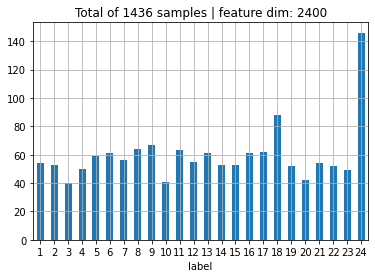

(1436, 2402)

In [ ]:
### Load smooth fft dataframe
winsize = 100
stride = 100
op = 'max'

df_to_load, ML_data = load_data_for_multicalss(winsize,stride,op, show_barplot=True)
ML_data.shape

#### Convert to binary classification / multiclass

### Split into train and test

In [ ]:
train_data, test_data = train_test_split(ML_data, test_size=0.15, stratify=ML_data['label'] ,random_state=10)

### Hyper-parameter tuning

#### Random Forest


In [ ]:

numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
# encode the labels 
le = LabelEncoder()
y = le.fit_transform(y)

# set running parameters
to_normalize = False
normalize_by_feature = False


if to_normalize:
  # choose scaler
  scaler = StandardScaler()
  # scaler = MinMaxScaler()

  if normalize_by_feature:
    # scaling each feature
    X = scaler.fit_transform(X)
  else:
    # scaling each row
    X = scaler.fit_transform(X.T).T


param_grid = {
    'max_depth': [5,10,20,30,40],
    'max_features': ['sqrt','log2'],
    'n_estimators': [200,400,600,700],
}

rf = RandomForestClassifier(random_state=10)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 3, return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X, y)
print(grid_search.best_params_)

# save tunning results (for visualizations purposes)
results_df_cols = ['param_max_depth','param_max_features','param_n_estimators','mean_train_score','std_train_score','mean_test_score','std_test_score']
grid_results = pd.DataFrame(grid_search.cv_results_).sort_values(['mean_test_score'], ascending=False)[results_df_cols].reset_index(drop=True)
snooth_df_name = df_to_load.split('.')[0]
grid_results.to_csv(f'/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_RF/{snooth_df_name}_CV.csv',index=False)
grid_results.head(3)

#### SVM

In [ ]:
#### SVM
numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
# encode the labels 
le = LabelEncoder()
y = le.fit_transform(y)

# set running parameters
to_normalize = True
normalize_by_feature = False
scaler_type = 'MinMax'
# scaler_type = 'Standart'

if to_normalize:
  # choose scaler
  if scaler_type == 'Standart':
    scaler = StandardScaler()
  elif scaler_type == 'MinMax':
    scaler = MinMaxScaler()

  if normalize_by_feature:
    # scaling each feature
    X = scaler.fit_transform(X)
  else:
    # scaling each row
    X = scaler.fit_transform(X.T).T


param_grid = {
  'kernel': ['linear', 'poly','rbf','sigmoid'],
  'C': [1,3,5,7],
  'gamma': ['scale','auto'],
}

svm = SVC(decision_function_shape='ovr', probability=False, random_state=10)
grid_search = GridSearchCV(estimator = svm, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 3, return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X, y)
print(grid_search.best_params_)

# save tunning results (for visualizations purposes)
results_df_cols = ['param_kernel','param_C','param_gamma','mean_train_score','std_train_score','mean_test_score','std_test_score']
grid_results = pd.DataFrame(grid_search.cv_results_).sort_values(['mean_test_score'], ascending=False)[results_df_cols].reset_index(drop=True)
snooth_df_name = df_to_load.split('.')[0]
grid_results.to_csv(f'/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_SVM/{snooth_df_name}_scale_{to_normalize}_type_{scaler_type}_colWise_{normalize_by_feature}_CV.csv',index=False)
grid_results.head(3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   33.7s finished


{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}


,param_kernel,param_C,param_gamma,mean_train_score,std_train_score,mean_test_score,std_test_score
0,rbf,5,scale,0.786885,0.006079,0.444262,0.020994
1,linear,5,auto,0.717828,0.008993,0.427869,0.021311
2,linear,5,scale,0.717828,0.008993,0.427869,0.021311


##### Explore CV results of SVC to choose the optimal dataset

In [ ]:
final_CV_results = pd.DataFrame(columns=['dataset','kernel','C','gamma','train_ACC','test_ACC'])

path = '/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_SVM'
for res_file in os.listdir(path):
  curr_res = pd.read_csv(f'{path}/{res_file}')
  new_record = {'dataset':res_file.split('.')[0],
                'kernel':curr_res.iloc[0]['param_kernel'],
                'C':curr_res.iloc[0]['param_C'],
                'gamma':curr_res.iloc[0]['param_gamma'],
                'train_ACC':curr_res.iloc[0]['mean_train_score'],
                'test_ACC':curr_res.iloc[0]['mean_test_score']}

  final_CV_results = final_CV_results.append(new_record,ignore_index=True).sort_values(['test_ACC'], ascending=False).reset_index(drop=True)
    
print(final_CV_results.iloc[0]['dataset'])
final_CV_results.iloc[0]

smooth_fft_winsize_100_stride_500_op_max_scale_True_type_MinMax_colWise_False_CV


dataset      smooth_fft_winsize_100_stride_500_op_max_scale...
kernel                                                     rbf
C                                                            5
gamma                                                    scale
train_ACC                                             0.908402
test_ACC                                              0.495082
Name: 0, dtype: object

##### Evaluate SVM on test set

In [ ]:
# load tunning results csv
to_normalize = True
normalize_by_feature = False
scaler_type = 'MinMax'
# scaler_type = 'Standart'

dataset = f'smooth_fft_winsize_{winsize}_stride_{stride}_op_{op}'
results_name = f'{dataset}_scale_{to_normalize}_type_{scaler_type}_colWise_{normalize_by_feature}_CV'
tunning_results = pd.read_csv(f'/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_SVM/{results_name}.csv')
tunning_results.iloc[0]

param_kernel               rbf
param_C                      5
param_gamma              scale
mean_train_score      0.908402
std_train_score     0.00460952
mean_test_score       0.495082
std_test_score       0.0178455
Name: 0, dtype: object

In [ ]:
# Evaluate on test set

print(f'Smooth FFT: {results_name} --|-- Dim: {train_data.shape[1]-2}')

numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
# encode the labels 
le = LabelEncoder()
y = le.fit_transform(y)

if to_normalize:
  if scaler_type == 'Standart':
    scaler = StandardScaler()
  elif scaler_type == 'MinMax':
    scaler = MinMaxScaler()

  if normalize_by_feature:
    # scaling each feature
    X = scaler.fit_transform(X)
  else:
    # scaling each row
    X = scaler.fit_transform(X.T).T

kernel_val = tunning_results.iloc[0]['param_kernel']
C_val = tunning_results.iloc[0]['param_C']
gamma_val = tunning_results.iloc[0]['param_gamma']

svc = SVC(kernel=kernel_val,C=C_val,gamma=gamma_val,decision_function_shape='ovr', probability=False, random_state=10)
svc.fit(X,y)

train_preds = svc.predict(X)

train_report = classification_report(y, train_preds, output_dict=True)
print('Train')
print(f'Accuracy:{round(train_report["accuracy"],3)} | F1:{round(train_report["macro avg"]["f1-score"],3)} | Recall:{round(train_report["macro avg"]["recall"],3)} | Precision:{round(train_report["macro avg"]["precision"],3)}')

## evaluate best configuration on the test set
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
Y_test = le.transform(Y_test)


if to_normalize:
  if normalize_by_feature:
    # scaling each feature
    X_test = scaler.transform(X_test)
  else:
    # scaling each row
    X_test = scaler.fit_transform(X_test.T).T

test_preds= svc.predict(X_test)

test_report = classification_report(Y_test, test_preds, output_dict=True)
print('Test')
print(f'Accuracy:{round(test_report["accuracy"],3)} | F1:{round(test_report["macro avg"]["f1-score"],3)} | Recall:{round(test_report["macro avg"]["recall"],3)} | Precision:{round(test_report["macro avg"]["precision"],3)}')


Smooth FFT: smooth_fft_winsize_100_stride_500_op_max_scale_True_type_MinMax_colWise_False_CV --|-- Dim: 480
Train
Accuracy:0.904 | F1:0.911 | Recall:0.898 | Precision:0.93
Test
Accuracy:0.551 | F1:0.519 | Recall:0.522 | Precision:0.539


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### MLP - sklearn

In [ ]:
#### MLP
numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
# encode the labels 
le = LabelEncoder()
y = le.fit_transform(y)

# set running parameters
to_normalize = True
normalize_by_feature = True
# scaler_type = 'MinMax'
scaler_type = 'Standart'

if to_normalize:
  # choose scaler
  if scaler_type == 'Standart':
    scaler = StandardScaler()
  elif scaler_type == 'MinMax':
    scaler = MinMaxScaler()

  if normalize_by_feature:
    # scaling each feature
    X = scaler.fit_transform(X)
  else:
    # scaling each row
    X = scaler.fit_transform(X.T).T

param_grid = {
  'hidden_layer_sizes': [(3000,3000), (1500,1500),(2500,2500),(3000)],
  'activation': ['relu'],
  'solver': ['sgd'],
  'learning_rate_init':[0.002, 0.02, 0.2],
  'max_iter': [100],
  'momentum': [0.1,0.6, 1],
}

mlp = MLPClassifier(random_state=10)
grid_search = GridSearchCV(estimator = mlp, param_grid = param_grid, 
                          cv = 5, n_jobs = 1, verbose = 3, return_train_score=True)

# Fit the grid search object to the data
grid_search.fit(X, y)
print(grid_search.best_params_)

# save tunning results (for visualizations purposes)
results_df_cols = ['param_hidden_layer_sizes','param_activation','param_solver','param_learning_rate_init','param_momentum','mean_train_score','std_train_score','mean_test_score','std_test_score']
grid_results = pd.DataFrame(grid_search.cv_results_).sort_values(['mean_test_score'], ascending=False)[results_df_cols].reset_index(drop=True)
snooth_df_name = df_to_load.split('.')[0]
csv_full_name = f'{snooth_df_name}_scale_{to_normalize}_type_{scaler_type}_colWise_{normalize_by_feature}_CV.csv'

if csv_full_name in os.listdir('/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_MLP_sklearn'):
  print('updating exist csv')
  exist_csv = pd.read_csv(f'/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_MLP_sklearn/{csv_full_name}')
  exist_csv = exist_csv.append(grid_results, ignore_index=True)
  exist_csv = exist_csv.sort_values(['mean_test_score'], ascending=False).reset_index(drop=True)
  exist_csv.to_csv(f'/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_MLP_sklearn/{csv_full_name}',index=False)
  print(exist_csv.head(5))
else:
  print('creating new csv')
  grid_results.to_csv(f'/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_MLP_sklearn/{csv_full_name}',index=False)
  print(grid_results.head(5))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd, score=(train=0.994, test=0.516), total= 5.2min
[CV] activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd, score=(train=0.995, test=0.512), total= 5.3min
[CV] activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.6min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd, score=(train=0.986, test=0.578), total= 5.2min
[CV] activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd, score=(train=0.978, test=0.504), total= 5.2min
[CV] activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(3000, 3000), learning_rate_init=0.03, max_iter=100, momentum=0.6, solver=sgd, score=(train=0.983, test=0.545), total= 5.3min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 26.4min finished


{'activation': 'relu', 'hidden_layer_sizes': (3000, 3000), 'learning_rate_init': 0.03, 'max_iter': 100, 'momentum': 0.6, 'solver': 'sgd'}
updating exist csv
  param_hidden_layer_sizes param_activation param_solver  \
0             (3000, 3000)             relu          sgd   
1                     3000             relu          sgd   
2             (1500, 1500)             relu          sgd   
3                     1500             relu          sgd   
4                     1500             relu          sgd   

  param_learning_rate_init  ... mean_train_score  std_train_score  \
0                     0.03  ...         0.987090         0.006369   
1                     0.02  ...         0.942828         0.004318   
2                     0.02  ...         0.963730         0.002869   
3                     0.02  ...         0.936885         0.002110   
4                     0.02  ...         0.936885         0.002110   

   mean_test_score  std_test_score  
0         0.531148        0.02

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### MLP - custome CV (TF implementation)

In [ ]:
## MLP

numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
# encode the labels 
le = LabelEncoder()
y = le.fit_transform(y)

# set running parameters
to_normalize = False
normalize_by_feature = False
folds_num = 10
feature_selection= False
top_k_features = 150

# set RandomForest param space
n_estimators = [50,150,300]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 50, num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

final_results_train = {'accuracy':[], 'F1':[], 'recall':[], 'precision':[]}
final_results_val = {'accuracy':[], 'F1':[], 'recall':[], 'precision':[]}

# init the feature ranikng for final feature selection
final_features_rankings = {f'col_{key}': 0 for key in range(X.shape[1])}

skf = StratifiedKFold(n_splits=folds_num, random_state=10, shuffle=True)
fold = 1
for train_index, val_index in skf.split(X, y):
  print(f'\n *** Fold {fold}: train size={len(train_index)} | validation size={len(val_index)} ***')
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]
  fold = fold + 1

  if feature_selection:
    # feature selection
    print(f'Selecting top {top_k_features} features using IG')
    features_IG = get_features_IG(X_train,y_train)
    selected_features = features_IG.head(top_k_features).index.tolist()
    # update the final_features_rankings dict
    for feature in selected_features:
      key_name = f'col_{feature}'
      final_features_rankings[key_name] += 1
    # select the top k features
    X_train = X_train[:,selected_features]
 
  if to_normalize:
    # choose scaler
    scaler = StandardScaler()
    # scaler = MinMaxScaler()

    if normalize_by_feature:
      # scaling each feature
      x_train = scaler.fit_transform(X_train)
    else:
      # scaling each row
      x_train = scaler.fit_transform(x_train.T).T

  rf = RandomForestClassifier(n_estimators= 100, max_depth=12, random_state=fold)
  rf.fit(X_train,y_train)

  # train_proba = svm.predict_proba(x_train)[:, 1] 
  train_preds = rf.predict(X_train)
  # evaluation metrices - Train
  # train_conf_matrix = multilabel_confusion_matrix(y_train, train_preds)
  report = classification_report(y_train, train_preds, output_dict=True, zero_division=0)
  final_results_train['accuracy'].append(round(report["accuracy"],3))
  final_results_train['F1'].append(round(report["macro avg"]['f1-score'],3))
  final_results_train['recall'].append(round(report["macro avg"]["recall"],3))
  final_results_train['precision'].append(round(report["macro avg"]["precision"],3))
  # print(f' Train: Accuracy:{round(report["accuracy"],3)} | F1:{round(report["macro avg"]["f1-score"],3)} | Recall:{round(report["macro avg"]["recall"],3)}')
  
  # ################  validation  #####################

  if feature_selection:
    # feature selection
    X_val = X_val[:,selected_features]

  if to_normalize:
    if normalize_by_feature:
      # scaling each feature
      X_val = scaler.transform(X_val)
    else:
      # scaling each row
      X_val = scaler.fit_transform(X_val.T).T

  val_preds= rf.predict(X_val)

  # val_conf_matrix = multilabel_confusion_matrix(y_val, val_preds)
  report = classification_report(y_val, val_preds, output_dict=True , zero_division=0)
  final_results_val['accuracy'].append(round(report["accuracy"],3))
  final_results_val['F1'].append(round(report["macro avg"]['f1-score'],3))
  final_results_val['recall'].append(round(report["macro avg"]["recall"],3))
  final_results_val['precision'].append(round(report["macro avg"]["precision"],3))
  # print(f' Validation: Accuracy:{round(report["accuracy"],3)} | F1:{round(report["macro avg"]["f1-score"],3)} | Recall:{round(report["macro avg"]["recall"],3)}')
  

## print the AVG results 
print('\n *********** Final Results *****************')
print(f'Train - Accuracy:{round(np.mean(final_results_train["accuracy"]),3)} | F1:{round(np.mean(final_results_train["F1"]),3)} | Recall:{round(np.mean(final_results_train["recall"]),3)}')
print(f'Val - Accuracy:{round(np.mean(final_results_val["accuracy"]),3)} | F1:{round(np.mean(final_results_val["F1"]),3)} | Recall:{round(np.mean(final_results_val["recall"]),3)}')

# get the top k used features among all folds
if feature_selection:
  col_indexes_to_use = []
  sorted_final_features_rankings = sorted(final_features_rankings.items(), key=lambda x: x[1], reverse=True)
  for element in sorted_final_features_rankings[0:top_k_features]:
    col_index = int(element[0].split('_')[1])
    col_indexes_to_use.append(col_index)

#### XGBoost

In [ ]:
#### XGBoost


################  training  #####################

# creating a DMatrix object for the xgb classifiers
numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, Y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

# # scaling each row
# scaler = StandardScaler()
# X = scaler.fit_transform(X.T)
# X = X.T

# scaling each feature
scaler = StandardScaler()
X = scaler.fit_transform(X)

dtrain = xgb.DMatrix(X, label=Y)

# Setting Parameters
param = {'max_depth': 2,
         'eta': 1,
         'objective': 'binary:logistic',
         'nthread':5,
         'eval_metric': 'auc',
         'verbosity':1,
         'seed':10}

evallist = [(dtrain, 'train')]

num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)

train_proba = bst.predict(dtrain)

classification_threshold = 0.3

## evaluation metrices - Train
train_pred = get_predictions(train_proba, threshold=classification_threshold)
train_conf_matrix = confusion_matrix(Y.tolist(), train_pred)
print('Train:',calc_metrics(train_conf_matrix, train_proba, Y.tolist()))


################  testing  #####################

# creating a DMatrix object for the xgb classifiers
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

# # scaling each row
# X_test = scaler.fit_transform(X_test.T)
# X_test = X_test.T

# scaling each feature
X_test = scaler.transform(X_test)

dtest = xgb.DMatrix(X_test)
test_proba= bst.predict(dtest)

## evaluation metrices - Test
test_pred = get_predictions(test_proba, threshold=classification_threshold)
test_conf_matrix = confusion_matrix(Y_test.tolist(), test_pred)
print('Test:',calc_metrics(test_conf_matrix, test_proba, Y_test.tolist()))

[0]	train-auc:0.570797
[1]	train-auc:0.597261
[2]	train-auc:0.605278
[3]	train-auc:0.61401
[4]	train-auc:0.629981
[5]	train-auc:0.641258
[6]	train-auc:0.649692
[7]	train-auc:0.652747
[8]	train-auc:0.662789
[9]	train-auc:0.671367
[10]	train-auc:0.677544
[11]	train-auc:0.683495
[12]	train-auc:0.686003
[13]	train-auc:0.69378
[14]	train-auc:0.702427
Train: {'TPR': 0.3, 'FPR': 0.1, 'ACC': 0.78, 'Precision': 0.46, 'F1_score': 0.37, 'AUC': 0.7024}
Test: {'TPR': 0.13, 'FPR': 0.14, 'ACC': 0.71, 'Precision': 0.2, 'F1_score': 0.16, 'AUC': 0.4931}


In [ ]:
#### Logistic Regression
# creating a DMatrix object for the xgb classifiers
numpy_dataset = train_data.values
# X- only features columns | Y- only class column
x_train, y_train = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

# scaling each feature
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

LR = LogisticRegression(C=0.5,max_iter=1000,random_state=10)
LR.fit(x_train,y_train.tolist())

train_proba = LR.predict_proba(x_train)[:, 1] 

classification_threshold = 0.5

## evaluation metrices - Train
train_pred = get_predictions(train_proba, threshold=classification_threshold)
train_conf_matrix = confusion_matrix(y_train.tolist(), train_pred)
print('Train:',calc_metrics(train_conf_matrix, train_proba, Y.tolist()))


################  testing  #####################

# creating a DMatrix object for the xgb classifiers
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

# # scaling each row
# X_test = scaler.fit_transform(X_test.T)
# X_test = X_test.T

# scaling each feature
X_test = scaler.transform(X_test)

test_proba = LR.predict_proba(X_test)[:, 1] 

## evaluation metrices - Test
test_pred = get_predictions(test_proba, threshold=classification_threshold)
test_conf_matrix = confusion_matrix(Y_test.tolist(), test_pred)
print('Test:',calc_metrics(test_conf_matrix, test_proba, Y_test.tolist()))

Train: {'TPR': 0.08, 'FPR': 0.0, 'ACC': 0.8, 'Precision': 0.85, 'F1_score': 0.14, 'AUC': 0.6885}
Test: {'TPR': 0.05, 'FPR': 0.03, 'ACC': 0.77, 'Precision': 0.28, 'F1_score': 0.08, 'AUC': 0.4706}


In [ ]:
#### SVM

# creating a DMatrix object for the xgb classifiers
numpy_dataset = train_data.values
# X- only features columns | Y- only class column
x_train, y_train = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

# scaling each feature
scaler = StandardScaler(with_mean=False)
x_train = scaler.fit_transform(x_train)

svm = SVC(kernel='rbf',probability=True,random_state=10)
svm.fit(x_train,y_train.tolist())

train_proba = svm.predict_proba(x_train)[:, 1] 

classification_threshold = 0.5
## evaluation metrices - Train
train_pred = get_predictions(train_proba, threshold=classification_threshold)
train_conf_matrix = confusion_matrix(y_train.tolist(), train_pred)
print('Train:',calc_metrics(train_conf_matrix, train_proba, Y.tolist()))

################  testing  #####################

# creating a DMatrix object for the xgb classifiers
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

# # scaling each row
# X_test = scaler.fit_transform(X_test.T)
# X_test = X_test.T

# scaling each feature
X_test = scaler.transform(X_test)
test_proba= svm.predict(X_test)
test_proba
## evaluation metrices - Test
test_pred = get_predictions(test_proba, threshold=classification_threshold)
test_conf_matrix = confusion_matrix(Y_test.tolist(), test_pred)
print('Test:',calc_metrics(test_conf_matrix, test_proba, Y_test.tolist()))

In [ ]:
#### XGBoost - multiclass

################  training  #####################

# creating a DMatrix object for the xgb classifiers
numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, Y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

le = LabelEncoder()
Y = le.fit_transform(Y)

# scaling each row
# scaler = MinMaxScaler()
scaler = StandardScaler()
X = scaler.fit_transform(X.T).T

# # scaling each feature
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

dtrain = xgb.DMatrix(X, label=Y)

# Setting Parameters
param = {'max_depth': 3,
         'num_class': 24,
         'eta': 1,
         'objective': 'multi:softmax',
         'nthread':5,
         'verbosity':1,
         'seed':10}

num_round = 12
bst = xgb.train(param, dtrain, num_round)
train_pred = bst.predict(dtrain)

classification_threshold = 0.5

## evaluation metrices - Train
train_conf_matrix = multilabel_confusion_matrix(Y.tolist(), train_pred)
report = classification_report(Y.tolist(), train_pred, output_dict=True)
print('Train')
print(f'Accuracy:{round(report["accuracy"],3)} | F1:{round(report["macro avg"]["f1-score"],3)} | Recall:{round(report["macro avg"]["recall"],3)} | Precision:{round(report["macro avg"]["precision"],3)}')

# ################  testing  #####################

# creating a DMatrix object for the xgb classifiers
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

Y_test =le.transform(Y_test)

# # scaling each row
X_test = scaler.fit_transform(X_test.T).T

# scaling each feature
# X_test = scaler.transform(X_test)
dtest = xgb.DMatrix(X_test)
test_pred= bst.predict(dtest)

## evaluation metrices - Test
test_conf_matrix = multilabel_confusion_matrix(Y_test.tolist(), test_pred)
report = classification_report(Y_test.tolist(), test_pred, output_dict=True)
print('Test')
print(f'Accuracy:{round(report["accuracy"],3)} | F1:{round(report["macro avg"]["f1-score"],3)} | Recall:{round(report["macro avg"]["recall"],3)} | Precision:{round(report["macro avg"]["precision"],3)}')

Train
Accuracy:1.0 | F1:1.0 | Recall:1.0 | Precision:1.0
Test
Accuracy:0.5 | F1:0.468 | Recall:0.467 | Precision:0.484


##### Random

In [ ]:
## random guesser - baseline

def random_multiclass_classifier(data):
  preds = [random.randint(0,23) for x in range(data.shape[0])]
  return preds
  

#### random_multiclass_classifier

# creating a DMatrix object for the xgb classifiers
numpy_dataset = train_data.values
# X- only features columns | Y- only class column
x_train, y_train = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

# encode the labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# train_proba = svm.predict_proba(x_train)[:, 1] 
train_preds = random_multiclass_classifier(x_train)
# evaluation metrices - Train
train_conf_matrix = multilabel_confusion_matrix(y_train.tolist(), train_preds)
report = classification_report(y_train.tolist(), train_preds, output_dict=True)
print('Train')
print(f'Accuracy:{round(report["accuracy"],3)} | F1:{round(report["macro avg"]["f1-score"],3)} | Recall:{round(report["macro avg"]["recall"],3)} | Precision:{round(report["macro avg"]["precision"],3)}')
# ################  testing  #####################

# creating a DMatrix object for the xgb classifiers
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]

Y_test = le.transform(Y_test)

test_preds= random_multiclass_classifier(X_test)

test_conf_matrix = multilabel_confusion_matrix(Y_test.tolist(), test_preds)
report = classification_report(Y_test.tolist(), test_preds, output_dict=True)
print('Test')
print(f'Accuracy:{round(report["accuracy"],3)} | F1:{round(report["macro avg"]["f1-score"],3)} | Recall:{round(report["macro avg"]["recall"],3)} | Precision:{round(report["macro avg"]["precision"],3)}')

Train
Accuracy:0.047 | F1:0.046 | Recall:0.045 | Precision:0.048
Test
Accuracy:0.042 | F1:0.041 | Recall:0.04 | Precision:0.045


### Compare CV results for different smoothings


#### RandomForest

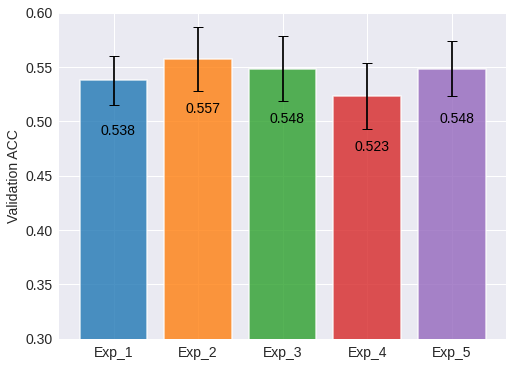

,Exp,Smooth_conf,max_depth,n_estimators
0,Exp_1,win:2500_stride:500_mean,25,600
1,Exp_2,win:2500_stride:500_max,20,600
2,Exp_3,win:2500_stride:2500_max,20,600
3,Exp_4,win:100_stride:500_max,25,600
4,Exp_5,win:1000_stride:150_mean,20,400


In [ ]:
tunning_path = '/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_RF'

smoothing_params = [
                    {'winsize':2500, 'stride':500, 'op':'mean'},
                    {'winsize':2500, 'stride':500, 'op':'max'},
                    {'winsize':2500, 'stride':2500, 'op':'max'},
                    {'winsize':100, 'stride':500, 'op':'max'},
                    {'winsize':1000, 'stride':150, 'op':'mean'},
]

final_conf_df = pd.DataFrame(columns=['Exp','Smooth_conf','max_depth','n_estimators'])

# Build the plot
fig, ax = plt.subplots(figsize=(8,6))
plt.style.use('seaborn')
error_kw = {'capsize': 5, 'capthick': 1, 'ecolor': 'black'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

exp_names = []
test_ACCs = []
test_stds = []
for idx,smooth_dict in enumerate(smoothing_params):
  winsize = smooth_dict['winsize']
  stride = smooth_dict['stride']
  op = smooth_dict['op']
  curr_csv_name = f'smooth_fft_winsize_{winsize}_stride_{stride}_op_{op}_CV.csv'
  curr_res = pd.read_csv(f'{tunning_path}/{curr_csv_name}').iloc[0]

  curr_test_acc = curr_res.mean_test_score
  curr_test_std = curr_res.std_test_score
  curr_max_depth = curr_res.param_max_depth
  curr_n_estimators = curr_res.param_n_estimators

  exp_name = f'Exp_{idx+1}'
  Smooth_conf = f'win:{winsize}_stride:{stride}_{op}'

  final_conf_df = final_conf_df.append({'Exp':exp_name,
                                        'Smooth_conf':Smooth_conf,
                                        'max_depth':curr_max_depth,
                                        'n_estimators':curr_n_estimators},ignore_index=True)
  exp_names.append(exp_name)
  test_ACCs.append(curr_test_acc)
  test_stds.append(curr_test_std)

  # Make the plot
  plt.bar(exp_name,curr_test_acc, yerr=curr_test_std, color=colors[idx],alpha=0.8,error_kw=error_kw, edgecolor='white',linewidth=1.5 ,label=idx)
  ax.text(idx-0.15, curr_test_acc -.05, str(round(curr_test_acc,3)), color='black', fontsize=14)
  plt.xticks(size=14)

# Add xticks on the middle of the group bars
# plt.title('RandomForest Cross-validation results',size=14)
plt.ylabel('Validation ACC', size=14)
plt.yticks(size=14)
plt.ylim([0.3,0.6])
# ax.xaxis.set_visible(False)
# plt.legend(smooth_conf,bbox_to_anchor=(1, 1), loc='upper left',fancybox=True, shadow=False,ncol=1,prop={'size': 12})
plt.show()

final_conf_df

#### SVM

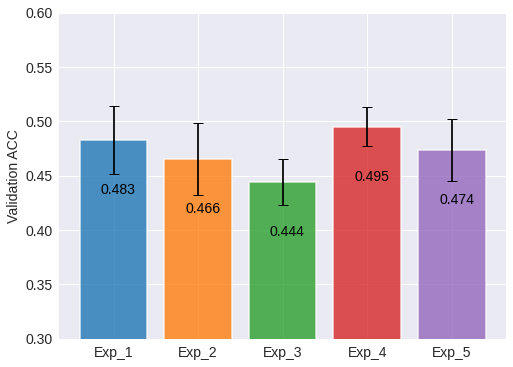

,Exp,Smooth_conf,Scaling,kernel,C,gamma
0,Exp_1,win:2500_stride:500_mean,scale_True_type_MinMax_colWise_False,rbf,5,scale
1,Exp_2,win:2500_stride:500_max,scale_True_type_MinMax_colWise_False,rbf,5,scale
2,Exp_3,win:2500_stride:2500_max,scale_True_type_MinMax_colWise_False,rbf,5,scale
3,Exp_4,win:100_stride:500_max,scale_True_type_MinMax_colWise_False,rbf,5,scale
4,Exp_5,win:100_stride:500_mean,scale_True_type_MinMax_colWise_False,rbf,5,scale


In [ ]:
tunning_path = '/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_SVM'

smoothing_params = [
  {'winsize':2500, 'stride':500, 'op':'max','scale':True,'type':'MinMax','colWise':False},
  {'winsize':2500, 'stride':500, 'op':'max','scale':True,'type':'Standart','colWise':True},
  {'winsize':2500, 'stride':500, 'op':'mean','scale':True,'type':'Standart','colWise':True},
  {'winsize':2500, 'stride':500, 'op':'mean','scale':True,'type':'MinMax','colWise':False},
  {'winsize':100, 'stride':500, 'op':'max','scale':True,'type':'MinMax','colWise':False},
  {'winsize':100, 'stride':500, 'op':'mean','scale':True,'type':'MinMax','colWise':False},
  {'winsize':100, 'stride':500, 'op':'mean','scale':True,'type':'Standart','colWise':True},
  {'winsize':100, 'stride':500, 'op':'max','scale':True,'type':'Standart','colWise':True},
]

smoothing_params = [
  {'winsize':2500, 'stride':500, 'op':'mean','scale':True,'type':'MinMax','colWise':False},
  {'winsize':2500, 'stride':500, 'op':'max','scale':True,'type':'MinMax','colWise':False},
  {'winsize':2500, 'stride':2500, 'op':'max','scale':True,'type':'MinMax','colWise':False},
  {'winsize':100, 'stride':500, 'op':'max','scale':True,'type':'MinMax','colWise':False},
  {'winsize':100, 'stride':500, 'op':'mean','scale':True,'type':'MinMax','colWise':False},
]

final_conf_df = pd.DataFrame(columns=['Exp','Smooth_conf','Scaling','kernel','C','gamma'])

# Build the plot
fig, ax = plt.subplots(figsize=(8,6))
plt.style.use('seaborn')
error_kw = {'capsize': 5, 'capthick': 1, 'ecolor': 'black'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#3333cc','#009933','#e68a00']

exp_names = []
test_ACCs = []
test_stds = []
for idx,smooth_dict in enumerate(smoothing_params):
  winsize = smooth_dict['winsize']
  stride = smooth_dict['stride']
  op = smooth_dict['op']
  scale = smooth_dict['scale']
  scale_type = smooth_dict['type']
  colWise = smooth_dict['colWise']

  curr_csv_name = f'smooth_fft_winsize_{winsize}_stride_{stride}_op_{op}_scale_{scale}_type_{scale_type}_colWise_{colWise}_CV.csv'
  curr_res = pd.read_csv(f'{tunning_path}/{curr_csv_name}').iloc[0]

  curr_test_acc = curr_res.mean_test_score
  curr_test_std = curr_res.std_test_score
  curr_kernel = curr_res.param_kernel
  curr_C = curr_res.param_C
  curr_gamma = curr_res.param_gamma

  exp_name = f'Exp_{idx+1}'
  Smooth_conf = f'win:{winsize}_stride:{stride}_{op}'
  Scaling = f'scale_{scale}_type_{scale_type}_colWise_{colWise}'

  final_conf_df = final_conf_df.append({'Exp':exp_name,
                                        'Smooth_conf':Smooth_conf,
                                        'Scaling': Scaling,
                                        'kernel':curr_kernel,
                                        'C':curr_C
                                        ,'gamma': curr_gamma},ignore_index=True)
  exp_names.append(exp_name)
  test_ACCs.append(curr_test_acc)
  test_stds.append(curr_test_std)

  # Make the plot
  plt.bar(exp_name,curr_test_acc, yerr=curr_test_std, color=colors[idx],alpha=0.8,error_kw=error_kw, edgecolor='white',linewidth=1.5 ,label=idx)
  ax.text(idx-0.15, curr_test_acc -.05, str(round(curr_test_acc,3)), color='black', fontsize=14)
  plt.xticks(size=14)

# Add xticks on the middle of the group bars
# plt.title('SVM Cross-validation results',size=14)
plt.ylabel('Validation ACC', size=14)
plt.yticks(size=14)
plt.ylim([0.3,0.6])
# ax.xaxis.set_visible(False)
# plt.legend(smooth_conf,bbox_to_anchor=(1, 1), loc='upper left',fancybox=True, shadow=False,ncol=1,prop={'size': 12})
plt.show()

final_conf_df

#### MLP

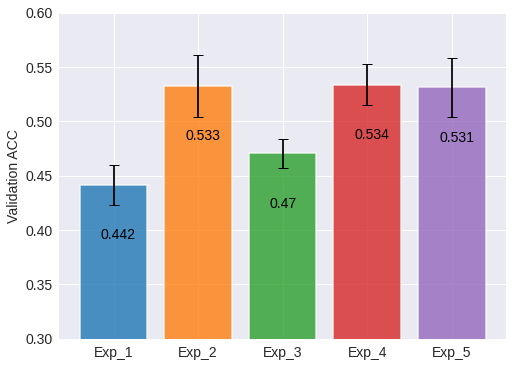

,Exp,Smooth_conf,Scaling,activation,solver,le,momentum,layers_shape
0,Exp_1,win:2500_stride:500_mean,scale_True_type_Standart_colWise_True,relu,sgd,0.02,0.6,"(2500, 2500)"
1,Exp_2,win:2500_stride:500_max,scale_True_type_Standart_colWise_True,relu,sgd,0.02,0.6,"(1500, 1500, 1500)"
2,Exp_3,win:1000_stride:150_mean,scale_True_type_Standart_colWise_True,relu,sgd,0.02,0.6,3000
3,Exp_4,win:1000_stride:150_max,scale_True_type_Standart_colWise_True,relu,sgd,0.02,0.6,3000
4,Exp_5,win:100_stride:100_max,scale_True_type_Standart_colWise_True,relu,sgd,0.03,0.6,"(3000, 3000)"


In [ ]:
tunning_path = '/content/drive/MyDrive/ML_2/main_project/Tuning_results/FFT_pipeline_MLP_sklearn'

smoothing_params = [
  {'winsize':2500, 'stride':500, 'op':'mean','scale':True,'type':'Standart','colWise':True},
  {'winsize':2500, 'stride':500, 'op':'max','scale':True,'type':'Standart','colWise':True},
  {'winsize':1000, 'stride':150, 'op':'mean','scale':True,'type':'Standart','colWise':True},
  {'winsize':1000, 'stride':150, 'op':'max','scale':True,'type':'Standart','colWise':True},
  {'winsize':100, 'stride':100, 'op':'max','scale':True,'type':'Standart','colWise':True},
]

final_conf_df = pd.DataFrame(columns=['Exp','Smooth_conf','Scaling','activation','solver','le','momentum','layers_shape'])

# Build the plot
fig, ax = plt.subplots(figsize=(8,6))
plt.style.use('seaborn')
error_kw = {'capsize': 5, 'capthick': 1, 'ecolor': 'black'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#3333cc','#009933','#e68a00']

exp_names = []
test_ACCs = []
test_stds = []
for idx,smooth_dict in enumerate(smoothing_params):
  winsize = smooth_dict['winsize']
  stride = smooth_dict['stride']
  op = smooth_dict['op']
  scale = smooth_dict['scale']
  scale_type = smooth_dict['type']
  colWise = smooth_dict['colWise']

  curr_csv_name = f'smooth_fft_winsize_{winsize}_stride_{stride}_op_{op}_scale_{scale}_type_{scale_type}_colWise_{colWise}_CV.csv'
  curr_res = pd.read_csv(f'{tunning_path}/{curr_csv_name}').iloc[0]

  curr_test_acc = curr_res.mean_test_score
  curr_test_std = curr_res.std_test_score
  curr_activation = curr_res.param_activation
  curr_solver = curr_res.param_solver
  curr_lr = curr_res.param_learning_rate_init
  curr_momentum = curr_res.param_momentum
  curr_layers_shape = curr_res.param_hidden_layer_sizes

  exp_name = f'Exp_{idx+1}'
  Smooth_conf = f'win:{winsize}_stride:{stride}_{op}'
  Scaling = f'scale_{scale}_type_{scale_type}_colWise_{colWise}'

  final_conf_df = final_conf_df.append({'Exp':exp_name,
                                        'Smooth_conf':Smooth_conf,
                                        'Scaling':Scaling,
                                        'activation':curr_activation,
                                        'solver':curr_solver,
                                        'le':curr_lr,
                                        'momentum':curr_momentum,
                                        'layers_shape':curr_layers_shape},ignore_index=True)
  exp_names.append(exp_name)
  test_ACCs.append(curr_test_acc)
  test_stds.append(curr_test_std)

  # Make the plot
  plt.bar(exp_name,curr_test_acc, yerr=curr_test_std, color=colors[idx],alpha=0.8,error_kw=error_kw, edgecolor='white',linewidth=1.5 ,label=idx)
  ax.text(idx-0.15, curr_test_acc -.05, str(round(curr_test_acc,3)), color='black', fontsize=14)
  plt.xticks(size=14)

# Add xticks on the middle of the group bars
# plt.title('MLP Cross-validation results',size=14)
plt.ylabel('Validation ACC', size=14)
plt.yticks(size=14)
plt.ylim([0.3,0.6])
# ax.xaxis.set_visible(False)
# plt.legend(smooth_conf,bbox_to_anchor=(1, 1), loc='upper left',fancybox=True, shadow=False,ncol=1,prop={'size': 12})
plt.show()

final_conf_df

### Evaluate on Test set

In [ ]:
# generate results dataframe 
columns = ['model','smooth','scaling','best_params','train_ACC','train_F1','test_ACC','test_F1']
results_df = pd.DataFrame(columns=columns)
# results_df.to_csv('/content/drive/MyDrive/ML_2/main_project/Test_results/FFT_results.csv',index=False)

#### RandomForest

Model: RandomForest --|-- Dim: 476
Train: Accuracy:1.0 | F1:1.0
Test: Accuracy:0.657 | F1:0.636


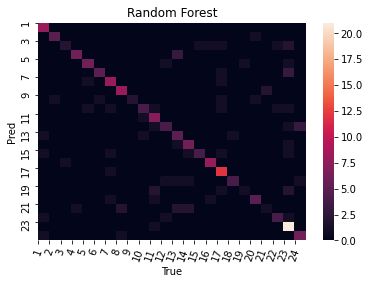

In [ ]:
# set the optimal params according to the CV stage
model_dict = {'model':'RandomForest',
              'winsize':2500,
              'stride': 500,
              'op': 'max',
              'scale':False,
              'scale_type': None,
              'colWise':None,
              'best_params': {'max_depth':20, 'n_estimators':600}}

# load the relevant dataset
df_to_load, ML_data = load_data_for_multicalss(model_dict['winsize'],model_dict['stride'],model_dict['op'], show_barplot=False)

# the split indexes are the same for all models due to the random_state
train_data, test_data = train_test_split(ML_data, test_size=0.15, stratify=ML_data['label'] ,random_state=10)

print(f'Model: {model_dict["model"]} --|-- Dim: {train_data.shape[1]-2}')

numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
# encode the labels 
le = LabelEncoder()
y = le.fit_transform(y)

max_depth_val = model_dict['best_params']['max_depth']
n_estimators_val = model_dict['best_params']['n_estimators']

rf = RandomForestClassifier(max_depth=max_depth_val,n_estimators=n_estimators_val, random_state=10)
rf.fit(X,y)

train_preds = rf.predict(X)
report = classification_report(y, train_preds, output_dict=True)

train_acc = round(report["accuracy"],3)
train_f1 = round(report["weighted avg"]["f1-score"],3)
print(f'Train: Accuracy:{train_acc} | F1:{train_f1}')

## evaluate best configuration on the test set
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
Y_test = le.transform(Y_test)

test_preds= rf.predict(X_test)

report = classification_report(Y_test, test_preds, output_dict=True)

test_acc = round(report["accuracy"],3)
test_f1 = round(report["weighted avg"]["f1-score"],3)
print(f'Test: Accuracy:{test_acc} | F1:{test_f1}')

# save results to csv
smooth = f'winsize_{model_dict["winsize"]}_stride_{model_dict["stride"]}_op_{model_dict["op"]}'
if model_dict['scale']:
  scaling = f'{model_dict["scale_type"]}_colWise_{model_dict["colWise"]}'
else:
  scaling = False

best_params = model_dict['best_params']

new_df_record = {'model':model_dict["model"],'smooth':smooth,'scaling':scaling,
                 'best_params':best_params,'train_ACC':train_acc,'train_F1':train_f1,'test_ACC':test_acc,'test_F1':test_f1}


creatMat(Y_test,test_preds,'Random Forest')

# FFT_results = pd.read_csv('/content/drive/MyDrive/ML_2/main_project/Test_results/FFT_results.csv')
# FFT_results = FFT_results.append(new_df_record, ignore_index=True).sort_values(['test_ACC'], ascending=False).reset_index(drop=True)
# FFT_results = FFT_results.drop_duplicates(subset=['model','smooth','scaling'])
# FFT_results.to_csv('/content/drive/MyDrive/ML_2/main_project/Test_results/FFT_results.csv', index=False)
# FFT_results

#### SVM

In [ ]:
# set the optimal params according to the CV stage
model_dict = {'model':'SVM',
              'winsize':100,
              'stride': 500,
              'op': 'max',
              'scale':True,
              'scale_type': 'MinMax',
              'colWise':False,
              'best_params': {'kernel':'rbf', 'C':5}} 
        
df_to_load, ML_data = load_data_for_multicalss(model_dict['winsize'],model_dict['stride'],model_dict['op'], show_barplot=False)

# the split indexes are the same for all models due to the random_state
train_data, test_data = train_test_split(ML_data, test_size=0.15, stratify=ML_data['label'] ,random_state=10)

print(f'Model: {model_dict["model"]} --|-- Dim: {train_data.shape[1]-2}')

numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
# encode the labels 
le = LabelEncoder()
y = le.fit_transform(y)

# set running parameters
to_normalize = model_dict['scale']
normalize_by_feature = model_dict['colWise']
scaler_type = model_dict['scale_type']

if to_normalize:
  if scaler_type == 'Standart':
    scaler = StandardScaler()
  elif scaler_type == 'MinMax':
    scaler = MinMaxScaler()

  if normalize_by_feature:
    # scaling each feature
    X = scaler.fit_transform(X)
  else:
    # scaling each row
    X = scaler.fit_transform(X.T).T

kernel_val = model_dict['best_params']['kernel']
C_val = model_dict['best_params']['C']

svc = SVC(kernel=kernel_val, C=C_val, decision_function_shape='ovr', probability=False, random_state=10)
svc.fit(X,y)

train_preds = svc.predict(X)

report = classification_report(y, train_preds, output_dict=True)

train_acc = round(report["accuracy"],3)
train_f1 = round(report["weighted avg"]["f1-score"],3)
print(f'Train: Accuracy:{train_acc} | F1:{train_f1}')


## evaluate best configuration on the test set
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
Y_test = le.transform(Y_test)


if to_normalize:
  if normalize_by_feature:
    # scaling each feature
    X_test = scaler.transform(X_test)
  else:
    # scaling each row
    X_test = scaler.fit_transform(X_test.T).T

test_preds= svc.predict(X_test)

report = classification_report(Y_test, test_preds, output_dict=True)

test_acc = round(report["accuracy"],3)
test_f1 = round(report["weighted avg"]["f1-score"],3)
print(f'Test: Accuracy:{test_acc} | F1:{test_f1}')


# save results to csv
smooth = f'winsize_{model_dict["winsize"]}_stride_{model_dict["stride"]}_op_{model_dict["op"]}'
if model_dict['scale']:
  scaling = f'{model_dict["scale_type"]}_colWise_{model_dict["colWise"]}'
else:
  scaling = False

best_params = model_dict['best_params']

new_df_record = {'model':model_dict["model"],'smooth':smooth,'scaling':scaling,
                 'best_params':best_params,'train_ACC':train_acc,'train_F1':train_f1,'test_ACC':test_acc,'test_F1':test_f1}

FFT_results = pd.read_csv('/content/drive/MyDrive/ML_2/main_project/Test_results/FFT_results.csv')
FFT_results = FFT_results.append(new_df_record, ignore_index=True).sort_values(['test_ACC'], ascending=False).reset_index(drop=True)
FFT_results = FFT_results.drop_duplicates(subset=['model','smooth','scaling'])
FFT_results.to_csv('/content/drive/MyDrive/ML_2/main_project/Test_results/FFT_results.csv', index=False)
FFT_results

Model: SVM --|-- Dim: 480
Train: Accuracy:0.904 | F1:0.906
Test: Accuracy:0.551 | F1:0.533


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,smooth,scaling,best_params,train_ACC,train_F1,test_ACC,test_F1
0,RandomForest,winsize_2500_stride_500_op_max,False,"{'max_depth': 20, 'n_estimators': 600}",1.000,1.000,0.657,0.636
1,SVM,winsize_100_stride_500_op_max,MinMax_colWise_False,"{'kernel': 'rbf', 'C': 5}",0.904,0.906,0.551,0.533


#### MLP

In [ ]:
# set the optimal params according to the CV stage
model_dict = {'model':'MLP',
              'winsize':1000,
              'stride': 150,
              'op': 'max',
              'scale':True,
              'scale_type': 'Standart',
              'colWise':True,
              'best_params': {'hidden_layer_sizes': (3000),
                              'activation': 'relu',
                              'solver': 'sgd',
                              'learning_rate_init':0.02,
                              'max_iter': 250,
                              'momentum': 0.6}} 
        
df_to_load, ML_data = load_data_for_multicalss(model_dict['winsize'],model_dict['stride'],model_dict['op'], show_barplot=False)

# the split indexes are the same for all models due to the random_state
train_data, test_data = train_test_split(ML_data, test_size=0.15, stratify=ML_data['label'] ,random_state=10)

print(f'Model: {model_dict["model"]} --|-- Dim: {train_data.shape[1]-2}')

numpy_dataset = train_data.values
# X- only features columns | Y- only class column
X, y = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
# encode the labels 
le = LabelEncoder()
y = le.fit_transform(y)

# set running parameters
to_normalize = model_dict['scale']
normalize_by_feature = model_dict['colWise']
scaler_type = model_dict['scale_type']

if to_normalize:
  if scaler_type == 'Standart':
    scaler = StandardScaler()
  elif scaler_type == 'MinMax':
    scaler = MinMaxScaler()

  if normalize_by_feature:
    # scaling each feature
    X = scaler.fit_transform(X)
  else:
    # scaling each row
    X = scaler.fit_transform(X.T).T

hidden_layer_sizes = model_dict['best_params']['hidden_layer_sizes']
activation = model_dict['best_params']['activation']
solver = model_dict['best_params']['solver']
learning_rate_init = model_dict['best_params']['learning_rate_init']
momentum = model_dict['best_params']['momentum']
max_iter = model_dict['best_params']['max_iter']

mlp = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                    activation = activation,
                    solver = solver,
                    learning_rate_init = learning_rate_init,
                    momentum = momentum,
                    max_iter = max_iter,
                    random_state=10)

mlp.fit(X,y)
train_preds = mlp.predict(X)

report = classification_report(y, train_preds, output_dict=True)

train_acc = round(report["accuracy"],3)
train_f1 = round(report["weighted avg"]["f1-score"],3)
print(f'Train: Accuracy:{train_acc} | F1:{train_f1}')


## evaluate best configuration on the test set
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
Y_test = le.transform(Y_test)


if to_normalize:
  if normalize_by_feature:
    # scaling each feature
    X_test = scaler.transform(X_test)
  else:
    # scaling each row
    X_test = scaler.fit_transform(X_test.T).T

test_preds= mlp.predict(X_test)

report = classification_report(Y_test, test_preds, output_dict=True)

test_acc = round(report["accuracy"],3)
test_f1 = round(report["weighted avg"]["f1-score"],3)
print(f'Test: Accuracy:{test_acc} | F1:{test_f1}')


# save results to csv
smooth = f'winsize_{model_dict["winsize"]}_stride_{model_dict["stride"]}_op_{model_dict["op"]}'
if model_dict['scale']:
  scaling = f'{model_dict["scale_type"]}_colWise_{model_dict["colWise"]}'
else:
  scaling = False

best_params = model_dict['best_params']

new_df_record = {'model':model_dict["model"],'smooth':smooth,'scaling':scaling,
                 'best_params':best_params,'train_ACC':train_acc,'train_F1':train_f1,'test_ACC':test_acc,'test_F1':test_f1}

FFT_results = pd.read_csv('/content/drive/MyDrive/ML_2/main_project/Test_results/FFT_results.csv')
FFT_results = FFT_results.append(new_df_record, ignore_index=True).sort_values(['test_ACC'], ascending=False).reset_index(drop=True)
FFT_results = FFT_results.drop_duplicates(subset=['model','smooth','scaling'])
FFT_results.to_csv('/content/drive/MyDrive/ML_2/main_project/Test_results/FFT_results.csv', index=False)
FFT_results

Model: MLP --|-- Dim: 1594


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Train: Accuracy:0.988 | F1:0.988
Test: Accuracy:0.569 | F1:0.557


,model,smooth,scaling,best_params,train_ACC,train_F1,test_ACC,test_F1
0,RandomForest,winsize_2500_stride_500_op_max,False,"{'max_depth': 20, 'n_estimators': 600}",1.000,1.000,0.657,0.636
1,MLP,winsize_1000_stride_150_op_max,Standart_colWise_True,"{'hidden_layer_sizes': 3000, 'activation': 're...",0.988,0.988,0.569,0.557
2,SVM,winsize_100_stride_500_op_max,MinMax_colWise_False,"{'kernel': 'rbf', 'C': 5}",0.904,0.906,0.551,0.533


### Compare Model's Test results

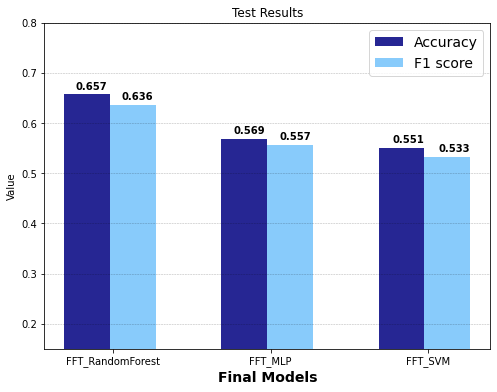

In [ ]:
pipe_1_results = pd.read_csv('/content/drive/MyDrive/ML_2/main_project/Test_results/FFT_results.csv')

x_labels = [f'FFT_{i}' for i in pipe_1_results['model']]

# Set plot parameters
fig, ax = plt.subplots(figsize=(8,6))
width = 0.35 # width of bar
x = np.arange(len(x_labels))

for idx,model in enumerate(pipe_1_results['model']):

  curr_results = pipe_1_results[pipe_1_results['model']==model]
  curr_test_acc = curr_results.test_ACC.values[0]
  curr_test_f1 = curr_results.test_F1.values[0]

  ax.bar(idx*1.2, curr_test_acc, width, color='#000080', label='Accuracy',alpha=.85)
  ax.text(idx*1.12 - (1-idx)*0.09 , curr_test_acc + .01, str(curr_test_acc), color='black', fontweight='bold')
  ax.bar(idx*1.2 + width, curr_test_f1, width, color='#73C2FB', label='F1 score',alpha=.85)
  ax.text(idx*1.12 + width -(1-idx)*0.09, curr_test_f1 + .01, str(round(curr_test_f1,3)), color='black', fontweight='bold')
  

ax.set_ylabel('Value')
ax.set_ylim(0.15,0.8)
ax.set_xticks([0.2,1.4,2.6]) # play with the positions to fit the figure
ax.set_xticklabels(x_labels)
ax.set_xlabel('Final Models', fontweight='bold', size=14)
ax.set_title('Test Results')
ax.legend(['Accuracy','F1 score'], fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

plt.savefig('/content/drive/MyDrive/ML_2/main_project/Test_results/Test_results_pipeline_1.png')
plt.show()

In [ ]:
## get test results for random guesser
random.seed(12)

# load the relevant dataset
df_to_load, ML_data = load_data_for_multicalss(2500,500,'max', show_barplot=False)
# the split indexes are the same for all models due to the random_state
train_data, test_data = train_test_split(ML_data, test_size=0.15, stratify=ML_data['label'] ,random_state=10)

## evaluate best configuration on the test set
numpy_dataset = test_data.values
# X- only features columns | Y- only class column
X_test, Y_test = numpy_dataset[:, 1:-1], numpy_dataset[:, -1]
Y_test = le.transform(Y_test)

y_preds = [random.randint(0,23) for i in range(test_data.shape[0])] 

report = classification_report(Y_test, y_preds, output_dict=True)

test_acc = round(report["accuracy"],3)
test_f1 = round(report["weighted avg"]["f1-score"],3)
print(f'Test: Accuracy:{test_acc} | F1:{test_f1}')

Test: Accuracy:0.042 | F1:0.041


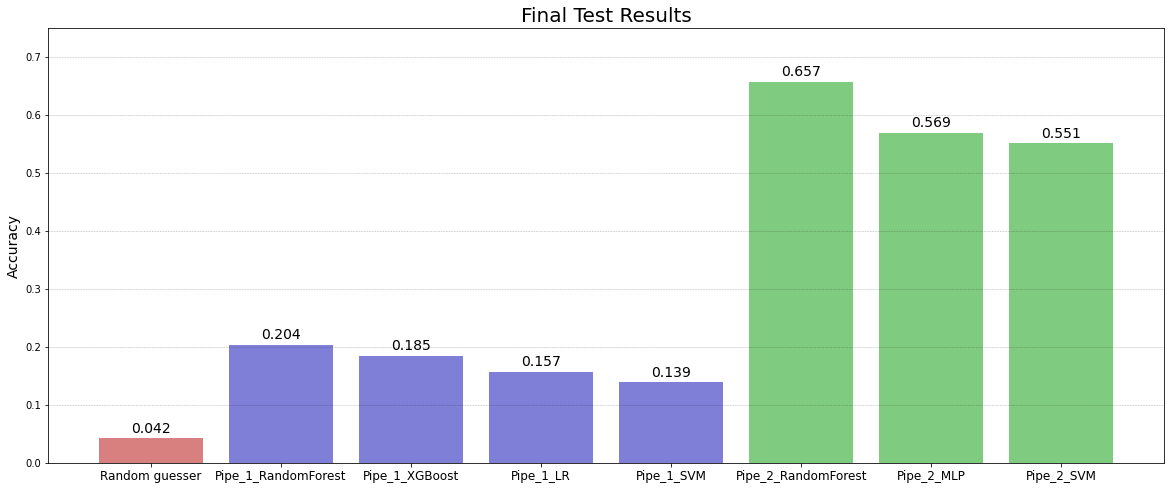

In [ ]:
#### models from all pipelines
models_name = ['Random guesser', 'Pipe_1_RandomForest', 'Pipe_1_XGBoost', 'Pipe_1_LR', 'Pipe_1_SVM', 'Pipe_2_RandomForest','Pipe_2_MLP','Pipe_2_SVM']

ACC_vals = [0.042, 0.204,0.185,0.157,0.139, 0.657,0.569, 0.551]
F1_vals = [0.041, 0.153,0.174,0.095,0.068, 0.636,0.557, 0.533]


# dark blue = #0000b3
# light blue = #73C2FB

# dark red = #b30000
# light red = #ff9999

# dark green = #009900
# light green = #80ff80

ACC_colors = ['#b30000','#0000b3','#0000b3','#0000b3','#0000b3','#009900','#009900','#009900']
F1_colors = ['#ff9999','#73C2FB','#73C2FB','#73C2FB','#73C2FB','#80ff80', '#80ff80','#80ff80']

labels_for_legend = ['Random', 'Time Domain','Time Domain','Time Domain','Time Domain','Frequency Domain','Frequency Domain','Frequency Domain']


# Set plot parameters
fig, ax = plt.subplots(figsize=(20,8))
# width = 0.5 # width of bar
x = np.arange(len(models_name))

for idx,model in enumerate(models_name):

  # curr_test_f1 = F1_vals[idx]

  ax.bar(model, ACC_vals[idx], color=ACC_colors[idx], label = labels_for_legend[idx],alpha=.5)
  ax.text(model, ACC_vals[idx] + .01, str(ACC_vals[idx]), color='black', size=14, horizontalalignment='center')
  # ax.bar(idx*1.2 + width, curr_test_f1, width, color=F1_colors[idx], label='F1 score',alpha=.85)
  # ax.text(idx*1.1 + width -(1-idx)*0.09, curr_test_f1 + .01, str(round(curr_test_f1,3)), color='black', fontweight='bold')
  

ax.set_ylabel('Accuracy', size=14)
ax.set_ylim(0,0.75)
# ax.set_xticks([0.25,1.45,2.65, 3.83, 5.048, 6.24, 7.45, 8.65]) # play with the positions to fit the figure
ax.set_xticklabels(models_name, size=12)
# ax.set_xlabel('Final Models', fontweight='bold', size=14)
ax.set_title('Final Test Results', size = 20)
# ax.legend(fontsize=15, loc=2)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)